# Image Compression with Singular Value Decomposition

This project will apply singular value decomposition to image compression, exploring performance on both gray-scale and color images.

I will be using an incredible photograph taken by Alberto Garcia in 1991, depciting a vehicle fleeing from the intensifying eruption of Mount Pinatubo in the Philippines.

Image compression is a cornerstone of modern digital technology, reducing storage requirements and accelerating data transfer while preserving visual quality. This project applies Singular Value Decomposition (SVD) to analyze and implement efficient compression techniques for both grayscale and color images, demonstrating its potential through a dramatic photograph capturing a vehicle's escape from the Mount Pinatubo eruption.

SVD decomposes a matrix into its singular vectors and singular values, allowing us to approximate the original image with reduced data while retaining most of its essential features.

Compression ratio quantifies how much storage is saved, while the recovered variance proportion measures the retained information, helping us balance file size and visual fidelity.

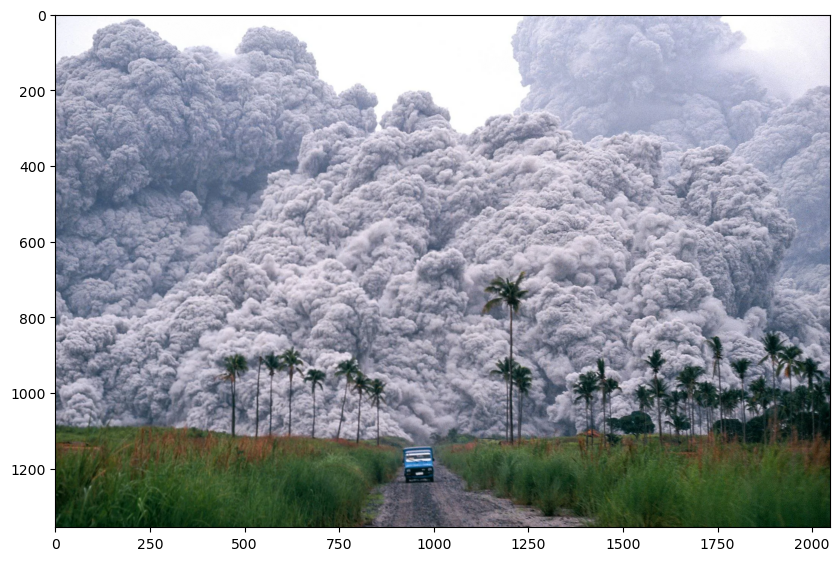

In [1]:
import numpy as np
from matplotlib import pyplot as plt
image = plt.imread("PinatuboEruption_Garcia1991.jpeg")/255.
fig = plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

## Introduction to the `ImgCompression` Class

The `ImgCompression` class leverages **Singular Value Decomposition (SVD)** for image compression. SVD is a mathematical technique that factorizes a matrix into three components: 

- **U:** A matrix containing the left singular vectors (spatial patterns).
- **S:** A diagonal matrix of singular values (relative importance of components).
- **V:** A matrix containing the right singular vectors (frequencies and directions).

In the context of image compression:
1. An image (grayscale or color) is treated as one or more matrices (one per color channel).
2. SVD decomposes these matrices, isolating the most significant patterns and features.
3. By retaining only the top-k singular values (and corresponding vectors), we can reconstruct an approximation of the original image.
4. This reduces the data size while retaining most visual information.

The `ImgCompression` class provides methods for:
- Decomposing an image using SVD.
- Reconstructing an image using a specified number of singular values (`k`).
- Calculating the compression ratio.
- Evaluating how much of the original image variance is retained.

In [2]:
class ImgCompression(object):
    def __init__(self):
        pass

    def svd(self, X): 
        #look at dimension of X to determine if color or gray-scale
        if X.ndim == 3:
            #split into red, green, blue color channels and apply SVD to each channel
            b, g, r = X[:, :, 0], X[:, :, 1], X[:, :, 2]

            u_b, s_b, v_b = np.linalg.svd(b)
            u_g, s_g, v_g = np.linalg.svd(g)
            u_r, s_r, v_r = np.linalg.svd(r)

            #stack results for all channels
            U = np.dstack((u_b,u_g,u_r))
            S = np.dstack((s_b,s_g,s_r))
            V = np.dstack((v_b,v_g,v_r))
        else:
            U, S, V = np.linalg.svd(X)

        return U,S,V


    def rebuild_svd(self, U, S, V, k):        
        if U.ndim == 3:
            #reconstruct each color channel
            Xrebuild = np.zeros((U.shape[0],V.shape[0],3))
            for i in range(3):
                val = np.dot(U[:,:k,i], np.dot(np.diag(S[0,:k,i]), V[:k,:,i]))
                Xrebuild[:,:,i] = val
        else:   
            Xrebuild = np.dot(U[:,:k],np.dot(np.diag(S[:k]),V[:k,:]))
        return Xrebuild
        
    def compression_ratio(self, X, k): 
        #formula: (compressed data) / (original data)
        return (k * (X.shape[0] + X.shape[1]) + k) / (X.shape[0] * X.shape[1])


    def recovered_variance_proportion(self, S, k):
        #calculate proportion of variance retained by color channel
        if S.ndim == 3:
            recovered_var = np.zeros(3)
            for i in range(3):
                recovered_var[i] = np.sum(S[0,:k,i]**2) / np.sum(S[0,:,i]**2)
        else:
            recovered_var = np.sum(S[:k]**2) / np.sum(S**2)
        return recovered_var

## Gray-scaled Image

Grayscale images simplify analysis by removing color information, reducing a 3D matrix into 2D and allowing us to focus on the fundamental aspects of SVD-based compression.

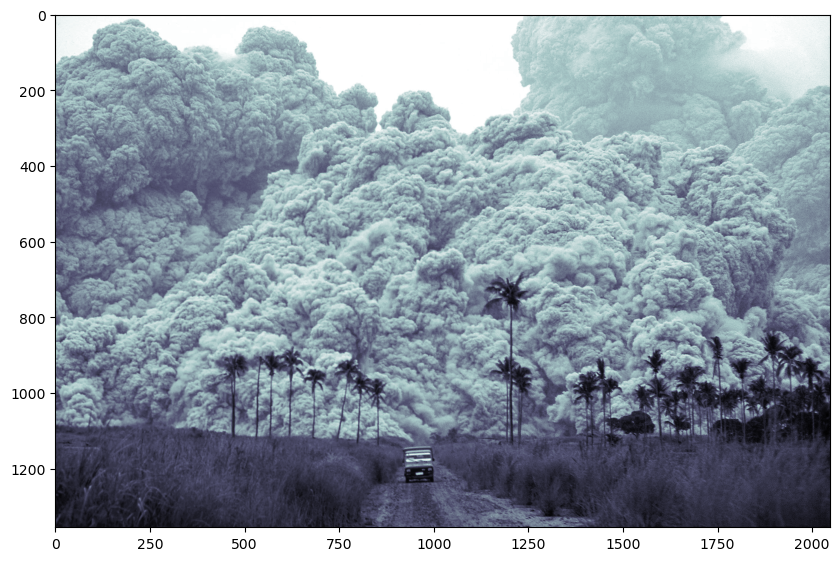

In [3]:
def rgb2gray(rgb):   
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

fig = plt.figure(figsize=(10, 10))
plt.imshow(rgb2gray(image), cmap=plt.cm.bone)
plt.show()

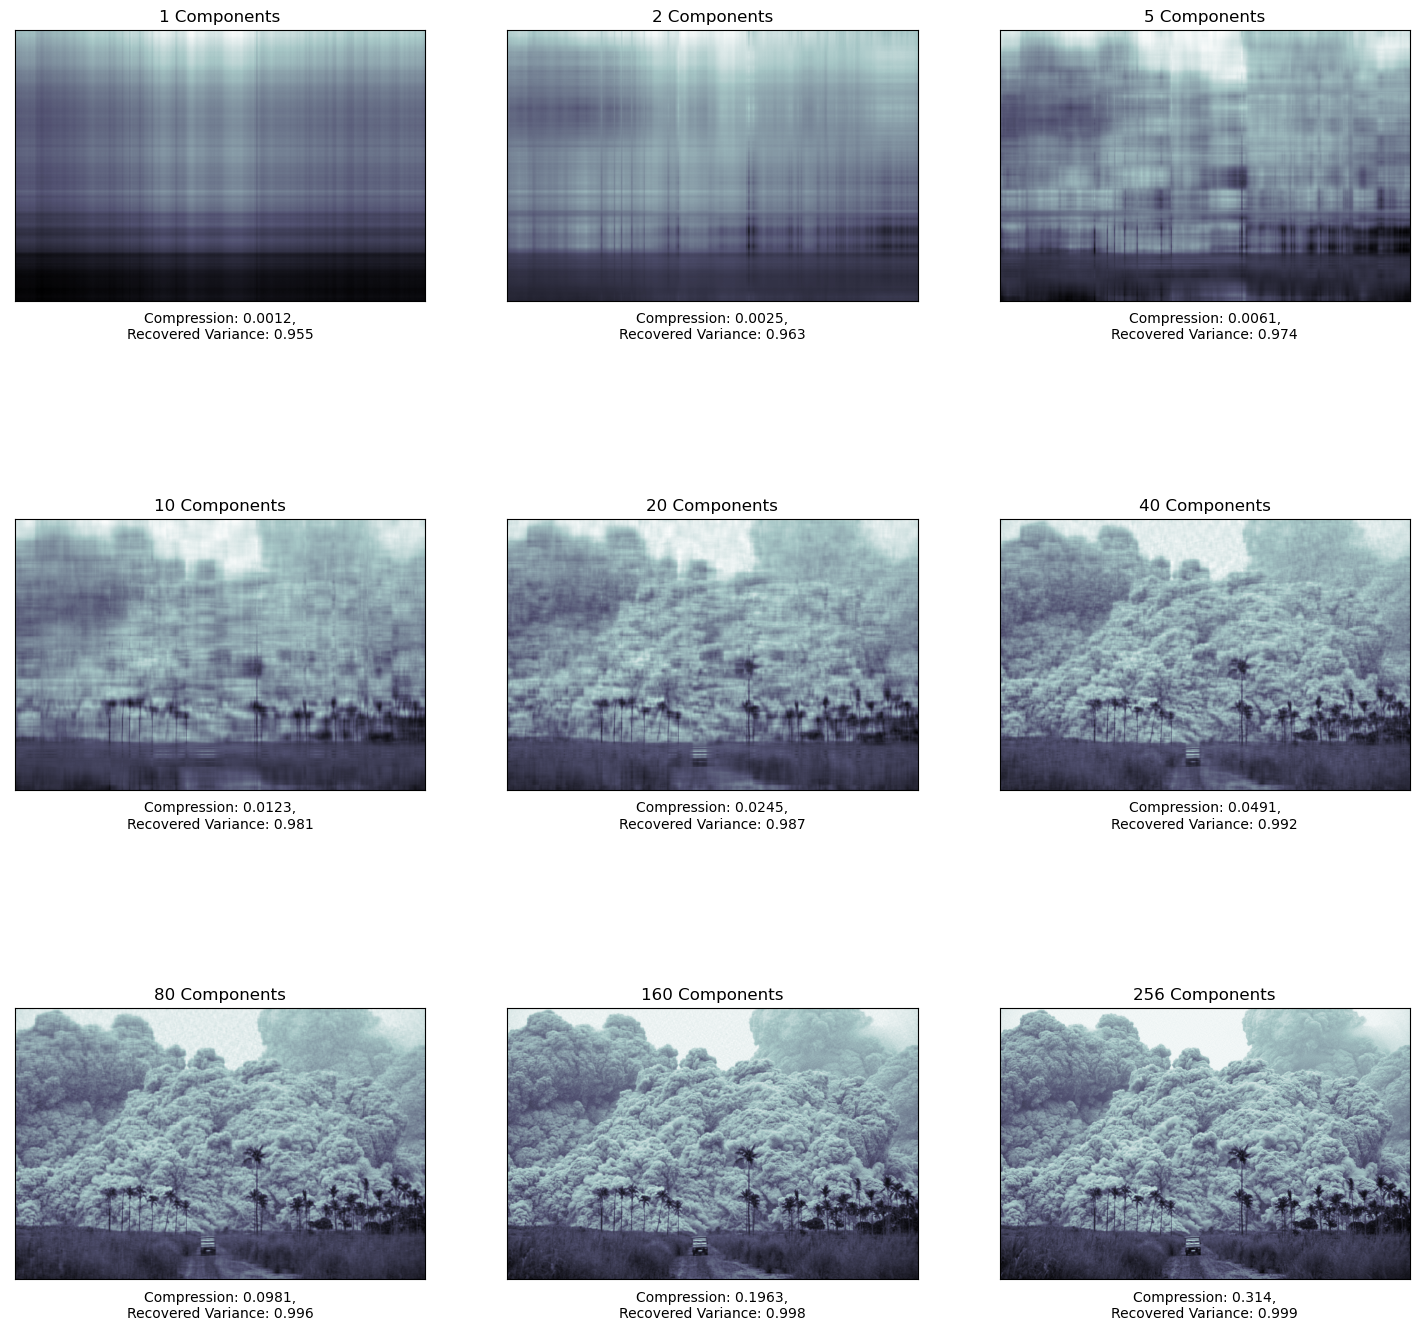

In [4]:
imcompression = ImgCompression()
bw_image = rgb2gray(image)
U, S, V = imcompression.svd(bw_image)
component_num = [1,2,5,10,20,40,80,160,256]

fig = plt.figure(figsize=(18, 18))

i=0
for k in component_num:
    img_rebuild = imcompression.rebuild_svd(U, S, V, k)
    c = np.around(imcompression.compression_ratio(bw_image, k), 4)
    r = np.around(imcompression.recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild, cmap=plt.cm.bone)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {c},\nRecovered Variance: {r}")
    i = i+1

As the number of components increases, the reconstructed grayscale images progressively approximate the original image, with sharper details emerging. Higher compression ratios show significant degradation, emphasizing the trade-off between storage savings and visual quality.

## Color Image

For color images, each channel (Red, Green, and Blue) is processed independently using SVD, ensuring that the compression retains the unique contributions of each color component to the overall image quality.

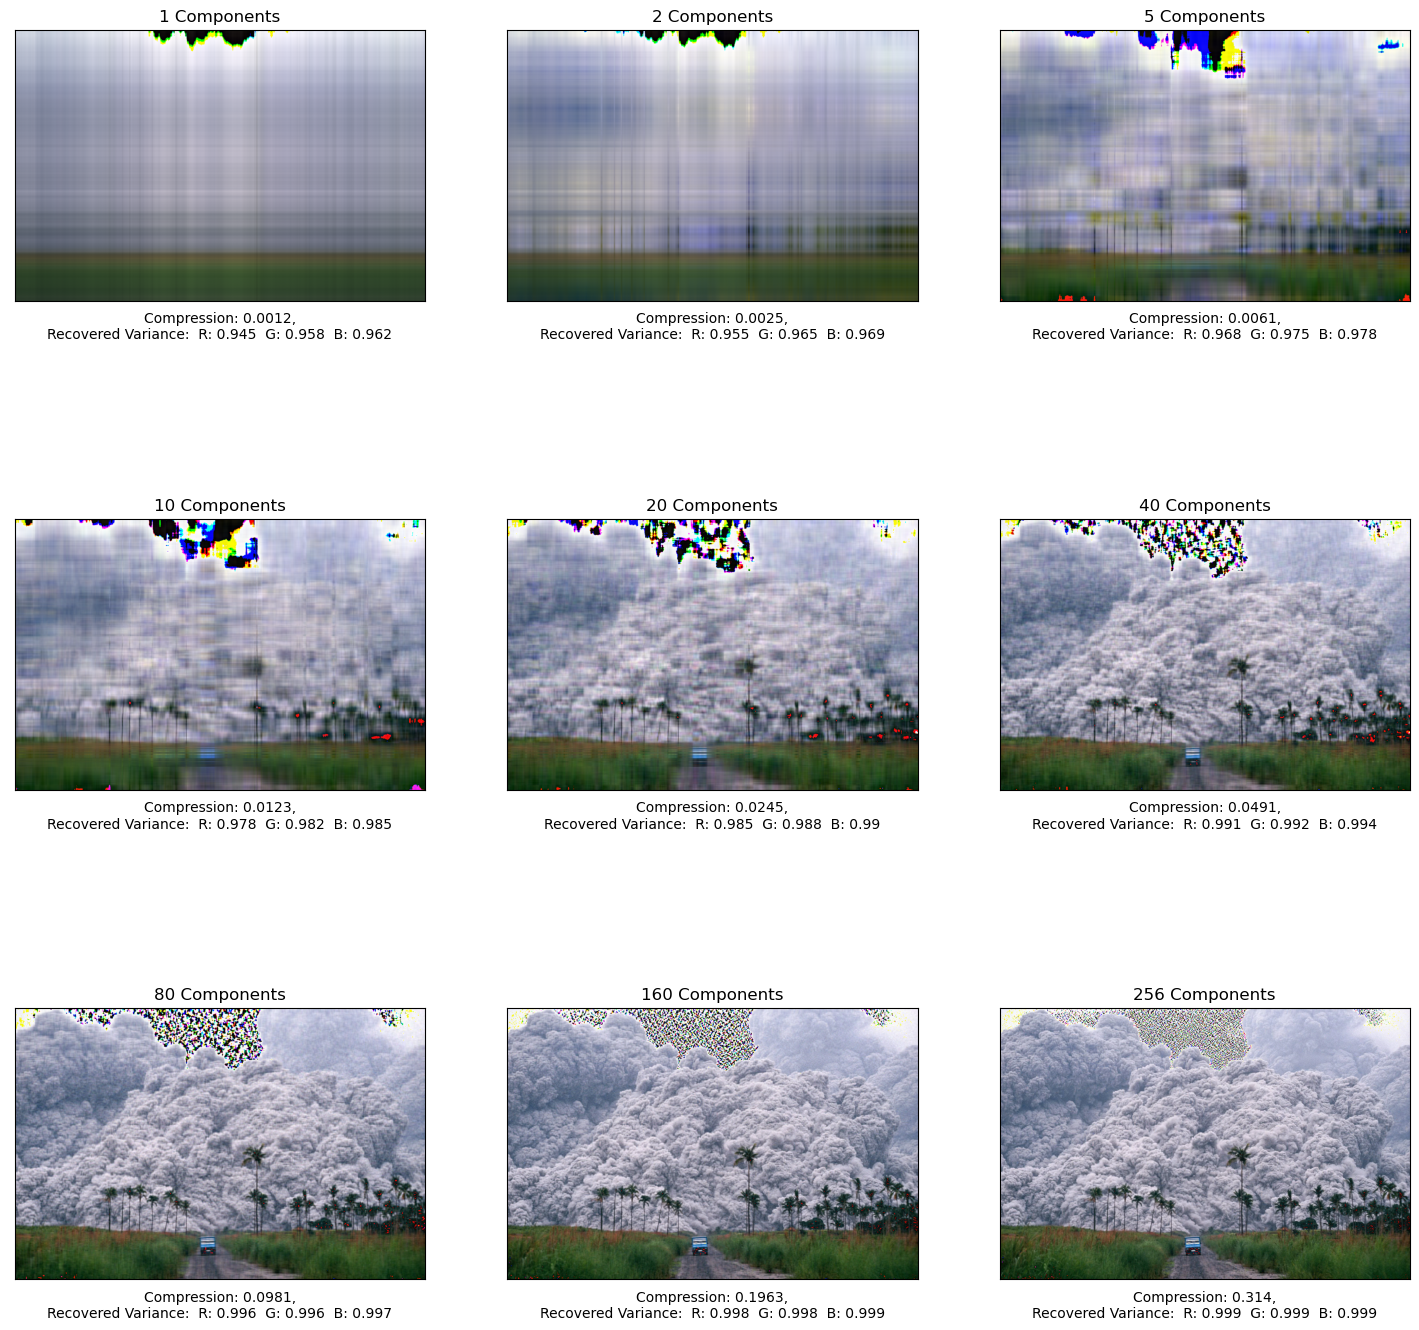

In [5]:
imcompression = ImgCompression()
U, S, V = imcompression.svd(image)
component_num = [1,2,5,10,20,40,80,160,256]

fig = plt.figure(figsize=(18, 18))

i=0
for k in component_num:
    img_rebuild = imcompression.rebuild_svd(U, S, V, k)
    c = np.around(imcompression.compression_ratio(image, k), 4)
    r = np.around(imcompression.recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow((img_rebuild * 255).astype(np.uint8))
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {np.around(c,4)},\nRecovered Variance:  R: {r[0]}  G: {r[1]}  B: {r[2]}")
    i = i+1

While grayscale compression focuses on intensity, color images involve three interdependent dimensions, making them more challenging to compress effectively without introducing artifacts or color distortions.

Despite impressive performance, the compressed images exhibit noise in uniform areas like the sky when the number of components is low. Addressing such artifacts may require advanced techniques, such as region-specific compression or applying weighted SVD.

Future work could explore incorporating Gaussian blur or wavelet transforms to handle noise more effectively or applying weighted SVD to prioritize key regions of the image. It would also be interesting to explore how this implementation generalizes to other images, particularly those on the extreme ends of complexity and uniformity. I would also be interested in the application to textual images. 